# Mounting the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/EVA5/Week11/")

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-2_c5n4ct
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-2_c5n4ct
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19775 sha256=03b84f832a191f962bd10ce646b185033798c4a32dde888393f10f3c1b5e5cd9
  Stored in directory: /tmp/pip-ephem-wheel-cache-jnjtrecg/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fsvvun7_
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fsvvun7_
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=69177 sha256=660cc834a72f3258964d419f3a38be8f865adcbcdfa73c46d3d1a38ab061b8a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-eid5vod9/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6


In [ ]:
!pip install torch-lr-finder

In [ ]:
!pip install torchsummary

## Importing Standard, Third-party and User-defined Libraries

In [ ]:
%matplotlib inline
from utils.CyclicLearningRate import CyclicLR
import time
import torch
from torchsummary import summary
from torchvision.utils import make_grid, save_image
import torch.nn as nn
import torch.optim as optim

import hiddenlayer as hl

from configs import basic_config

from data.data_loaders.base_data_loader import BaseDataLoader
from data.base_data_utils import get_data_loaders
from data.base_data_utils import sample_data
from data.base_data_utils import show_train_data
from data.data_transforms.base_data_transforms import UnNormalize

from utils.misc_utils import get_device_type, current_config
from utils.visualization_utils import plot_multigraph, plot_misclassified_images, plot_LR_graph, visualize_clr
from utils import logger_utils

from models.networks.resnet_davidnet import ResNetDavidNet
from models.model_builder import build_model
from models.gradcam.utils import visualize_cam
from models.gradcam.gradcam import GradCAM
from models.gradcam.gen_gradcam import generate_grad_cam_grid,generate_missclassified_gradcam_grid,upgraded_missclassified_gradcam_grid
from models.learning_rates.lr_range_test import LRRangeFinder
from models.build_graph import draw_graph


from orchestrators.base_orchestrator import start_training
from orchestrators.base_orchestrator import display_classwise_accuracy

## 1. Triangular Scheduler

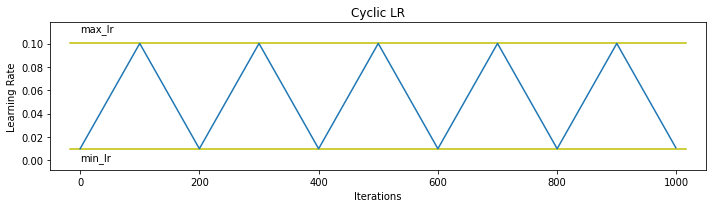

In [ ]:
max_lr = 0.10004247448979592
min_lr = (max_lr/10)
step_size = 100
iteration = step_size*10
triangular_sch = CyclicLR(max_lr,min_lr,step_size,iteration)
triangular_sch.cyclic_lr(plot=True)

## Configuration for the project

In [ ]:
current_config()

EPOCHS - 24
OrderedDict - <class 'collections.OrderedDict'>
SEED - 1
agumentation_package - Albumentation
cuda - True
data - {'img_augs': OrderedDict([('PadIfNeeded', {'min_height': 40, 'min_width': 40, 'border_mode': 0, 'value': (0.4914, 0.4822, 0.4465), 'p': 1.0}), ('oneof_crop', {'randomcrop': {'height': 32, 'width': 32, 'p': 0.9}, 'centercrop': {'height': 32, 'width': 32, 'p': 0.1}, 'p': 1.0}), ('fliplr', {'p': 0.7}), ('cutout', {'num_holes': 3, 'max_h_size': 8, 'max_w_size': 8, 'fill_value': (0.4914, 0.4822, 0.4465), 'always_apply': False, 'p': 0.6})]), 'normalize_paras': [(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201)], 'dataloader_args': {'shuffle': True, 'batch_size': 512, 'num_workers': 16, 'pin_memory': True}, 'data_kind': {'dataset_type': 'open_datasets', 'dataset_name': 'CIFAR10', 'datasets_location': 'data/datasets'}}
l1_lambda - 0.0
logger_config - {'log_filename': 'logs/Session11_assignment', 'level': 20, 'format': '%(asctime)s %(levelname)-8s [%(filename)s:%(lineno)d

In [ ]:
logger = logger_utils.get_logger(__name__)

## Creating Train and Test Data Loaders

In [ ]:
train_loader, test_loader = get_data_loaders(dataset_name='cifar10')


**** Started Loading data ****

Files already downloaded and verified
CUDA Available? True
Files already downloaded and verified
CUDA Available? True
CUDA Available? True

**** Ended Loading data ****



## Peek at Sample Data

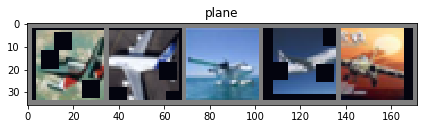

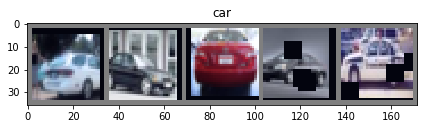

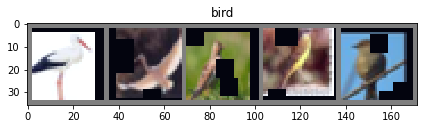

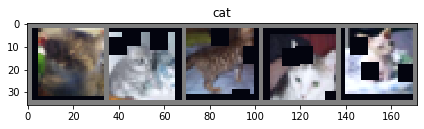

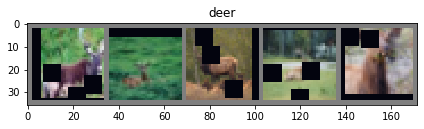

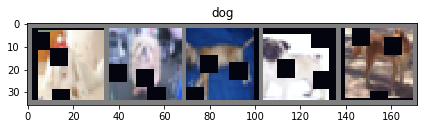

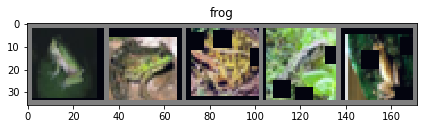

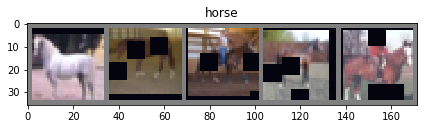

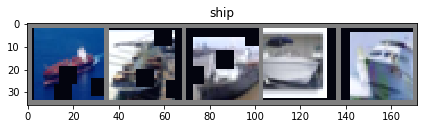

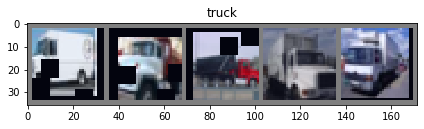

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
show_train_data(train_loader, classes)

## Creating Model

In [ ]:
def get_model():
  device = get_device_type()
  return ResNetDavidNet().to(device)

In [ ]:
model = get_model()

## Network Summary

In [ ]:
def print_summary(network,title):
  print(title)
  summary(network,input_size=(3,32,32))

In [ ]:
print_summary(model,'Network summary')

Network summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14   

/content/drive/My Drive/EVA5/Week11/models/networks/ResenetEzhirko.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


/content/drive/My Drive/EVA5/Week11/models/networks/ResenetEzhirko.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:438: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


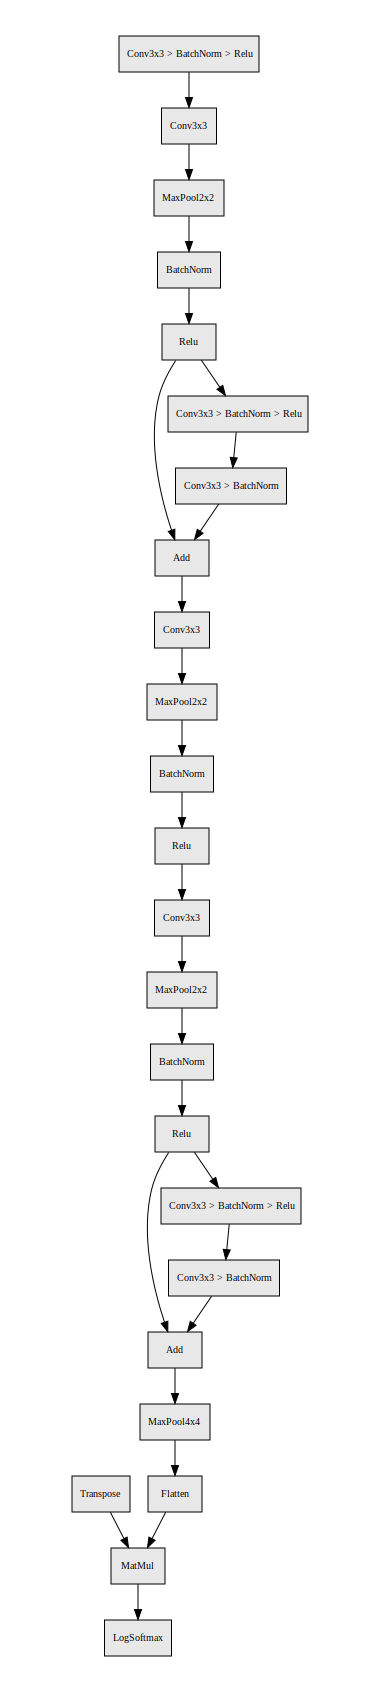

In [ ]:
device = get_device_type()
input = torch.zeros([1, 3, 32, 32]).to(device)
draw_graph(model, input, view='TD')

In [ ]:
def lr_range_test(model,start_lr, end_lr, step_mode, epochs, sgd_lr=5.34E-02, sgd_momentum=0.9):
  print(f'\n\n***** Started LR Test with step_mode={step_mode}, start_lr={start_lr}, end_lr={end_lr} *****\n\n')
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)
  lr_finder = LRRangeFinder(model, optimizer, criterion, device=device)
  lr_finder.range_test(train_loader, val_loader=test_loader, start_lr=start_lr, end_lr=end_lr,
                      epochs=epochs, step_mode=step_mode)
  lr_finder.plot(metric='acc', skip_start=0, skip_end=0)
  lr_finder.reset()
  best_acc = lr_finder.best_acc
  best_lr = lr_finder.history["lr"][lr_finder.history["acc"].index(best_acc)]
  print("Best Accuracy: %s\nBest Learning Rate: %s" % (best_acc, best_lr))
  print(f'\n\n***** Ended LR Test with step_mode={step_mode}, start_lr={start_lr}, end_lr={end_lr} *****\n\n')

In [ ]:
linear_lr_pairs = [(1E-4, 0.1),]  ## Add pairs for lr range test in linear mode
exp_lr_pairs = [(1E-7,1E-1),] ## Add pairs for lr range test in exponential mode



***** Started LR Test with step_mode=linear, start_lr=0.0001, end_lr=0.1 *****




/content/drive/My Drive/EVA5/Week11/models/networks/ResenetEzhirko.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


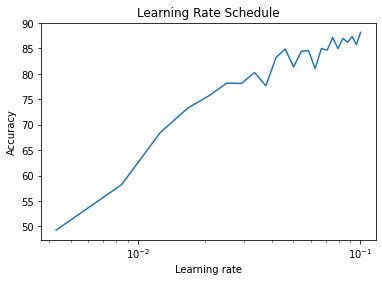

Best Accuracy: 88.15
Best Learning Rate: 0.10004247448979592


***** Ended LR Test with step_mode=linear, start_lr=0.0001, end_lr=0.1 *****




In [ ]:
## Linear Step Mode
for start_lr, end_lr in linear_lr_pairs:
  model = get_model()
  lr_range_test(model, start_lr, end_lr, 'linear', 24, sgd_lr=5.34E-02, sgd_momentum=0.9)  

## Preparing for Training

In [ ]:
device = get_device_type()
model = get_model()

EPOCHS = basic_config.EPOCHS
device = get_device_type()
results = {}

models_dict = {'resnet_davidnet': {'model': model}
          }

## Start Training

In [ ]:
results = start_training(EPOCHS, device, train_loader, test_loader, **models_dict)

  0%|          | 0/98 [00:00<?, ?it/s]


**** Started training ****


Model: resnet_davidnet

0 0
Optimizer paras: optimizer=sgd, lr=0.0534,momentum=0.9, weight_decay=0.0
LR Scheduler paras: {'max_lr': 0.10004247448979592, 'epochs': 24, 'pct_start': 0.20833333333333334, 'steps_per_epoch': 98, 'cycle_momentum': False, 'div_factor': 10, 'final_div_factor': 1, 'anneal_strategy': 'linear', 'name': 'OneCycleLR'}
[EPOCH:1]

Current LR: 0.010004247448979592



/content/drive/My Drive/EVA5/Week11/models/networks/ResenetEzhirko.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Epoch=1 Iteration=98 Loss=1.7484967708587646 Batch_id=97 Current_train_batch_accuracy=29.26: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Train set: Average loss: 1.6956, Accuracy: 20246/50000 (40.49%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5760, Accuracy: 4423/10000 (44.23%)

best_test_accuracy 44.23
[EPOCH:2]

Current LR: 0.028048718307875295



Epoch=2 Iteration=196 Loss=1.5076501369476318 Batch_id=97 Current_train_batch_accuracy=46.49: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 1.4566, Accuracy: 24621/50000 (49.24%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4135, Accuracy: 5114/10000 (51.14%)

best_test_accuracy 51.14
[EPOCH:3]

Current LR: 0.046093189166771



Epoch=3 Iteration=294 Loss=1.4481580257415771 Batch_id=97 Current_train_batch_accuracy=58.27: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Train set: Average loss: 1.6367, Accuracy: 24067/50000 (48.13%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5071, Accuracy: 5245/10000 (52.45%)

best_test_accuracy 52.45
[EPOCH:4]

Current LR: 0.0641376600256667



Epoch=4 Iteration=392 Loss=1.1192203760147095 Batch_id=97 Current_train_batch_accuracy=65.08: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Train set: Average loss: 1.3594, Accuracy: 28331/50000 (56.66%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2654, Accuracy: 6075/10000 (60.75%)

best_test_accuracy 60.75
[EPOCH:5]

Current LR: 0.08218213088456242



Epoch=5 Iteration=490 Loss=0.820236086845398 Batch_id=97 Current_train_batch_accuracy=70.55: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Train set: Average loss: 1.1542, Accuracy: 32253/50000 (64.51%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0268, Accuracy: 6829/10000 (68.29%)

best_test_accuracy 68.29
[EPOCH:6]

Current LR: 0.09999411883617572



Epoch=6 Iteration=588 Loss=0.6462814211845398 Batch_id=97 Current_train_batch_accuracy=73.63: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 0.7970, Accuracy: 37515/50000 (75.03%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7356, Accuracy: 7743/10000 (77.43%)

best_test_accuracy 77.43
[EPOCH:7]

Current LR: 0.09525526478139591



Epoch=7 Iteration=686 Loss=0.5295071601867676 Batch_id=97 Current_train_batch_accuracy=78.69: 100%|██████████| 98/98 [00:44<00:00,  2.18it/s]



Train set: Average loss: 0.6889, Accuracy: 39056/50000 (78.11%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6843, Accuracy: 7875/10000 (78.75%)

best_test_accuracy 78.75
[EPOCH:8]

Current LR: 0.0905164107266161



Epoch=8 Iteration=784 Loss=0.6225990056991577 Batch_id=97 Current_train_batch_accuracy=80.89: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 0.6242, Accuracy: 40929/50000 (81.86%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6554, Accuracy: 8195/10000 (81.95%)

best_test_accuracy 81.95
[EPOCH:9]

Current LR: 0.0857775566718363



Epoch=9 Iteration=882 Loss=0.439924418926239 Batch_id=97 Current_train_batch_accuracy=82.89: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 0.5017, Accuracy: 41272/50000 (82.54%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4911, Accuracy: 8334/10000 (83.34%)

best_test_accuracy 83.34
[EPOCH:10]

Current LR: 0.0810387026170565



Epoch=10 Iteration=980 Loss=0.42653292417526245 Batch_id=97 Current_train_batch_accuracy=84.53: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Train set: Average loss: 0.4262, Accuracy: 42731/50000 (85.46%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4562, Accuracy: 8440/10000 (84.40%)

best_test_accuracy 84.4
[EPOCH:11]

Current LR: 0.07629984856227669



Epoch=11 Iteration=1078 Loss=0.36859917640686035 Batch_id=97 Current_train_batch_accuracy=85.97: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Train set: Average loss: 0.3818, Accuracy: 43349/50000 (86.70%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4206, Accuracy: 8617/10000 (86.17%)

best_test_accuracy 86.17
[EPOCH:12]

Current LR: 0.07156099450749688



Epoch=12 Iteration=1176 Loss=0.35351043939590454 Batch_id=97 Current_train_batch_accuracy=87.13: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Train set: Average loss: 0.3313, Accuracy: 44197/50000 (88.39%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3883, Accuracy: 8705/10000 (87.05%)

best_test_accuracy 87.05
[EPOCH:13]

Current LR: 0.06682214045271706



Epoch=13 Iteration=1274 Loss=0.3134436011314392 Batch_id=97 Current_train_batch_accuracy=88.43: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Train set: Average loss: 0.3350, Accuracy: 44189/50000 (88.38%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4093, Accuracy: 8663/10000 (86.63%)

best_test_accuracy 87.05
[EPOCH:14]

Current LR: 0.06208328639793726



Epoch=14 Iteration=1372 Loss=0.3756670355796814 Batch_id=97 Current_train_batch_accuracy=89.04: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 0.3118, Accuracy: 44504/50000 (89.01%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3927, Accuracy: 8725/10000 (87.25%)

best_test_accuracy 87.25
[EPOCH:15]

Current LR: 0.05734443234315746



Epoch=15 Iteration=1470 Loss=0.3220398426055908 Batch_id=97 Current_train_batch_accuracy=90.01: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Train set: Average loss: 0.2773, Accuracy: 45196/50000 (90.39%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3908, Accuracy: 8775/10000 (87.75%)

best_test_accuracy 87.75
[EPOCH:16]

Current LR: 0.052605578288377655



Epoch=16 Iteration=1568 Loss=0.19881398975849152 Batch_id=97 Current_train_batch_accuracy=90.93: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 0.2466, Accuracy: 45643/50000 (91.29%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3600, Accuracy: 8824/10000 (88.24%)

best_test_accuracy 88.24
[EPOCH:17]

Current LR: 0.04786672423359785



Epoch=17 Iteration=1666 Loss=0.28003209829330444 Batch_id=97 Current_train_batch_accuracy=91.64: 100%|██████████| 98/98 [00:44<00:00,  2.21it/s]



Train set: Average loss: 0.2260, Accuracy: 46083/50000 (92.17%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3656, Accuracy: 8824/10000 (88.24%)

best_test_accuracy 88.24
[EPOCH:18]

Current LR: 0.04312787017881804



Epoch=18 Iteration=1764 Loss=0.20656690001487732 Batch_id=97 Current_train_batch_accuracy=92.36: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Train set: Average loss: 0.2044, Accuracy: 46339/50000 (92.68%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3473, Accuracy: 8883/10000 (88.83%)

best_test_accuracy 88.83
[EPOCH:19]

Current LR: 0.03838901612403823



Epoch=19 Iteration=1862 Loss=0.2264101803302765 Batch_id=97 Current_train_batch_accuracy=92.92: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Train set: Average loss: 0.1722, Accuracy: 47024/50000 (94.05%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3300, Accuracy: 8971/10000 (89.71%)

best_test_accuracy 89.71
[EPOCH:20]

Current LR: 0.03365016206925843



Epoch=20 Iteration=1960 Loss=0.14893591403961182 Batch_id=97 Current_train_batch_accuracy=93.60: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Train set: Average loss: 0.1643, Accuracy: 47177/50000 (94.35%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3205, Accuracy: 8971/10000 (89.71%)

best_test_accuracy 89.71
[EPOCH:21]

Current LR: 0.028911308014478623



Epoch=21 Iteration=2058 Loss=0.14071740210056305 Batch_id=97 Current_train_batch_accuracy=94.13: 100%|██████████| 98/98 [00:44<00:00,  2.19it/s]



Train set: Average loss: 0.1542, Accuracy: 47358/50000 (94.72%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3299, Accuracy: 8983/10000 (89.83%)

best_test_accuracy 89.83
[EPOCH:22]

Current LR: 0.024172453959698817



Epoch=22 Iteration=2156 Loss=0.1676112413406372 Batch_id=97 Current_train_batch_accuracy=94.84: 100%|██████████| 98/98 [00:44<00:00,  2.22it/s]



Train set: Average loss: 0.1332, Accuracy: 47709/50000 (95.42%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3177, Accuracy: 9039/10000 (90.39%)

best_test_accuracy 90.39
[EPOCH:23]

Current LR: 0.01943359990491901



Epoch=23 Iteration=2254 Loss=0.10883034765720367 Batch_id=97 Current_train_batch_accuracy=95.13: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Train set: Average loss: 0.1239, Accuracy: 47887/50000 (95.77%)



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3222, Accuracy: 9013/10000 (90.13%)

best_test_accuracy 90.39
[EPOCH:24]

Current LR: 0.014694745850139204



Epoch=24 Iteration=2352 Loss=0.10264112055301666 Batch_id=97 Current_train_batch_accuracy=95.64: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Train set: Average loss: 0.1158, Accuracy: 47996/50000 (95.99%)


Test set: Average loss: 0.3064, Accuracy: 9055/10000 (90.55%)

best_test_accuracy 90.55

results : {'resnet_davidnet': [[40.492, 49.242, 48.134, 56.662, 64.506, 75.03, 78.112, 81.858, 82.544, 85.462, 86.698, 88.394, 88.378, 89.008, 90.392, 91.286, 92.166, 92.678, 94.048, 94.354, 94.716, 95.418, 95.774, 95.992], [1.6956222009277344, 1.4565887255859375, 1.6367356646728515, 1.3593643786621095, 1.154175629272461, 0.7969502746582031, 0.6889389218139649, 0.62423123046875, 0.5016794192504883, 0.42617075500488283, 0.3818119091796875, 0.33126730575561525, 0.33502715057373045, 0.311839095916748, 0.27725881591796875, 0.24657234878540038, 0.22597821212768554, 0.2043759571838379, 0.17221737754821778, 0.16429449714660643, 0.15417407302856445, 0.1331737631225586, 0.12393771247863769, 0.11577515441894531], [44.23, 51.14, 52.45, 60.75, 68.29, 77.43, 78.75, 81.95, 83.34, 84.4, 86.17, 87.05, 86.63, 87.25, 87.75, 88.24, 88.24, 88.83, 89.71

In [ ]:
torch.save(model, f'check_points/Session11_assignment_epochs_{EPOCHS}.h5')

In [ ]:
lst_plottingJobs_acc = []
lst_plottingLegends_acc = []
lst_plotting_loss = []
lst_plottingLegends_loss = []
lst_plotting_lr = []
lst_plottingLegends_lr = []

for model_type in results:
  lst_plottingJobs_acc.append(results[model_type][0])
  lst_plottingJobs_acc.append(results[model_type][2])
  
  lst_plottingLegends_acc.append('Training accuracy')
  lst_plottingLegends_acc.append('Validation accuracy')

  lst_plotting_loss.append(results[model_type][1])
  lst_plotting_loss.append(results[model_type][3])

  lst_plottingLegends_loss.append('Training loss')
  lst_plottingLegends_loss.append('Validation loss')

  lst_plotting_lr.append(results[model_type][5])
  lst_plottingLegends_lr.append('Learning Rate')

## Plotting model evaluation results


**** Started Plotting multigraph ****



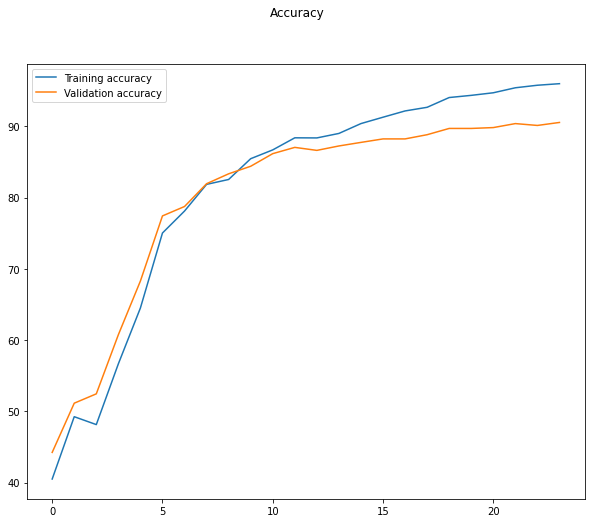


**** Ended Plotting multigraph ****



In [ ]:
plot_multigraph(lst_plottingJobs_acc,lst_plottingLegends_acc,title="Accuracy")


**** Started Plotting multigraph ****



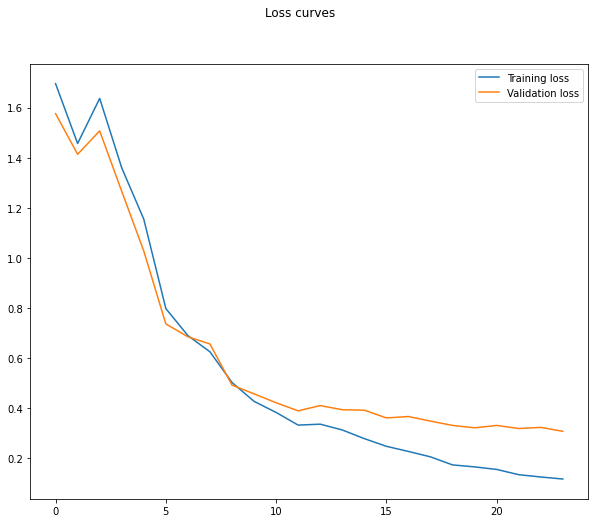


**** Ended Plotting multigraph ****



In [ ]:
plot_multigraph(lst_plotting_loss,lst_plottingLegends_loss,title="Loss curves")

## Plotting Change in Learning rate during model training


**** Started Plotting multigraph ****



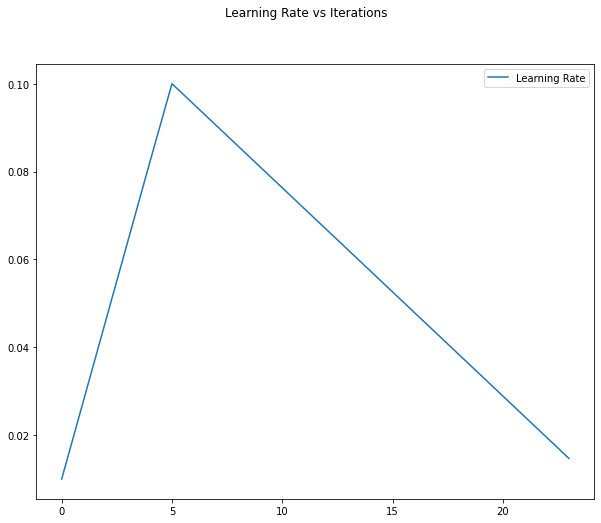


**** Ended Plotting multigraph ****



In [ ]:
plot_multigraph(lst_plotting_lr,lst_plottingLegends_lr,title="Learning Rate vs Iterations")

## Plotting Loss curve at different learning rates during the model Training


**** Started Plotting Graph ****



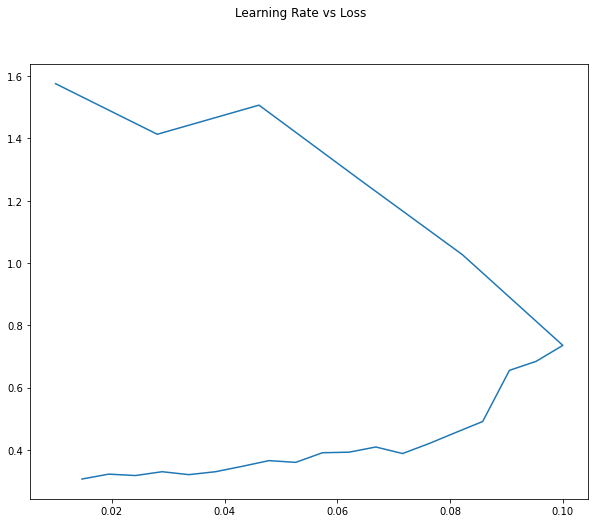


**** Ended Plotting multigraph ****



In [ ]:
plot_LR_graph(results[model_type][3],results[model_type][5],'Learning Rate vs Loss')

## Classwise accuracies

In [ ]:
display_classwise_accuracy(test_loader,device,model,classes)

/content/drive/My Drive/EVA5/Week11/models/networks/ResenetEzhirko.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 100.0
Accuracy of car : 100.0
Accuracy of bird : 90.0
Accuracy of cat : 100.0
Accuracy of deer : 91.66666666666667
Accuracy of dog : 100.0
Accuracy of frog : 90.9090909090909
Accuracy of horse : 88.88888888888889
Accuracy of ship : 100.0
Accuracy of truck : 100.0


##GradCam Visualization of Miss classified images

In [ ]:
#model =torch.load(f'check_points/Session11_assignment_epochs_24.h5')

In [ ]:
configs = [dict(model_type='resnet', arch=model, layer_name='layer3')]

/content/drive/My Drive/EVA5/Week11/models/networks/ResenetEzhirko.py:82: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


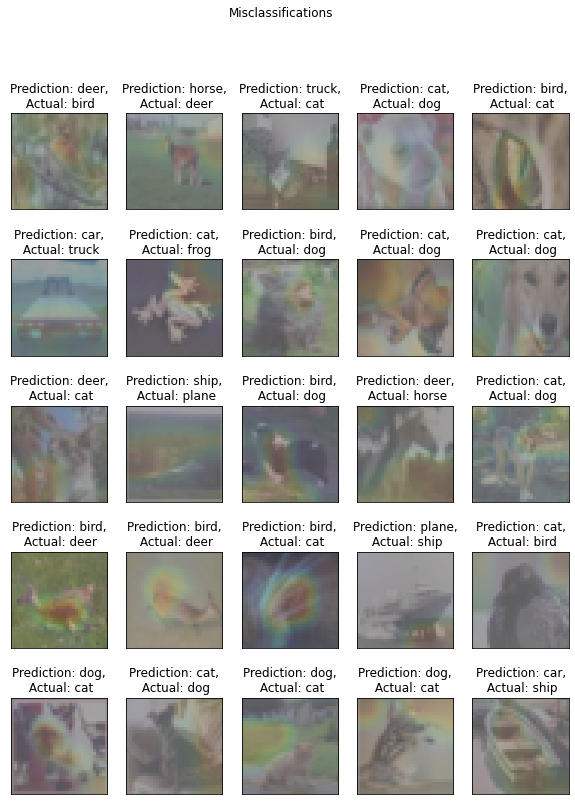

In [ ]:
generate_missclassified_gradcam_grid(configs, classes, test_loader, device, model, matched=True, num_of_images=25)